In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# Chapter 4 — Supervised Learning Basics
## Lesson 2: Linear Regression: Concept and Applications


### What you will learn in this lesson

Linear Regression is the canonical starting point for supervised learning: it is simple enough to understand end‑to‑end, yet rich enough to teach the core workflow used for many real models.

By the end of this notebook you will be able to:

- Explain the **problem setting** of regression and what “linear” means in practice.
- Derive the **objective function** for Ordinary Least Squares (OLS) and interpret it geometrically.
- Train linear regression models using **scikit‑learn** and interpret coefficients in real datasets.
- Handle **categorical variables** using one‑hot encoding and build **pipelines** that avoid leakage.
- Evaluate models using **MAE**, **MSE**, **RMSE**, and **$R^2$**, and diagnose errors using **residual plots**.
- Understand key assumptions (linearity, independence, homoscedasticity) and what to do when they fail.
- Implement a tiny **gradient descent** solver from scratch to see what training is really doing.
- Use multiple datasets (not just one) to understand how linear regression behaves across domains.

We will apply linear regression to **three different datasets** from your repository:

1. `house-prices.csv` (classic tabular regression with a small categorical feature)
2. `diamonds.csv` (mixed numeric + categorical, many rows; we will sample)
3. `salaries.csv` (tiny dataset; shows instability and the need for careful evaluation)

All dataset paths use your repository structure, e.g. `../../../Datasets/Regression/house-prices.csv`.

---

### Why you still care about linear regression in 2026

Even if you ultimately deploy gradient boosting, random forests, or deep learning, linear regression remains a high‑value tool because it is:

- **A baseline**: You need a sanity check. If a complex model cannot beat a good linear baseline, something is wrong (data leakage, evaluation bug, label noise, misaligned target).
- **An interpretability anchor**: It clarifies the direction of relationships and helps stakeholders reason about units (“per additional square foot”).
- **A diagnostic instrument**: Residual plots, leverage, and outlier behavior teach you what the data is doing.
- **A building block**: Many models reduce to (or contain) linear components: generalized linear models, ridge/lasso, linear calibration, linear embeddings, etc.

In addition, linear regression offers an opportunity to practice the most transferable skills in supervised learning:

- constructing features and targets correctly,
- preventing leakage via pipelines,
- splitting data properly,
- selecting metrics aligned with business cost,
- interpreting and communicating results.

---

### Notation (lightweight)

We will use the following notation in markdown sections:

- $n$ = number of samples
- $d$ = number of features (after preprocessing)
- $\mathbf{X}\in\mathbb{R}^{n\times d}$ = feature matrix
- $\mathbf{y}\in\mathbb{R}^n$ = target vector
- $\boldsymbol{\beta}\in\mathbb{R}^d$ = coefficient vector
- $\beta_0$ = intercept
- $\hat{\mathbf{y}}$ = model predictions



## 1) Linear regression in one sentence

Linear regression learns a function that predicts a **continuous** target $y$ from features $x$ by assuming the prediction is a **linear combination** of the features.

In its simplest form (one feature):

$$
\hat{y} = \beta_0 + \beta_1 x
$$

With $d$ features ($x \in \mathbb{R}^d$):

$$
\hat{y} = \beta_0 + \sum_{j=1}^{d}\beta_j x_j
$$

Matrix form (useful for derivations). Let $\mathbf{X}\in\mathbb{R}^{n\times d}$ be the design matrix (rows are samples), $\mathbf{y}\in\mathbb{R}^{n}$ be targets, and $\boldsymbol{\beta}\in\mathbb{R}^d$ coefficients:

$$
\hat{\mathbf{y}} = \beta_0\mathbf{1} + \mathbf{X}\boldsymbol{\beta}
$$

### “Linear” does **not** mean “a straight line in the raw input”

“Linear” refers to linearity in the **parameters** $(\beta_0, \beta_1, \dots, \beta_d)$, not necessarily linearity in the original raw variables.

Examples that are still “linear regression” (linear in parameters):

- Polynomial features: $\hat{y} = \beta_0 + \beta_1 x + \beta_2 x^2$
- Interactions: $\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 (x_1 x_2)$
- Log transforms: $\hat{y} = \beta_0 + \beta_1 \log(x)$

Once you transform features, the model remains linear in $\beta$ while capturing nonlinear patterns in the original space.

### Typical applications (and why they work)

Linear regression is widely used when:

- You need **interpretability** (coefficient signs and magnitudes matter).
- You need a **fast baseline** before trying more complex models.
- The relationship is approximately linear after feature engineering.
- You want **quantitative attribution** (e.g., “how much does price change per additional square foot?”).

A useful mental model: linear regression is a **best linear approximation** to the conditional expectation $E[y\mid x]$ (under squared loss). Even when the true relationship is not exactly linear, the learned model can still provide a strong baseline.

### Where linear regression can fail

Linear regression can underperform when:

- The relationship is strongly nonlinear and not fixable with simple features.
- Errors have heavy tails / outliers dominate the fit.
- Predictors are highly collinear, making coefficients unstable.
- The target has skewness or heteroskedastic noise without transformation.

We will see how to detect these issues and what practical mitigations exist.



## 2) The OLS objective: why “least squares”?

Given training data $\{(x^{(i)}, y^{(i)})\}_{i=1}^{n}$, we choose parameters to minimize the sum of squared residuals:

- Residual for sample $i$: $e^{(i)} = y^{(i)} - \hat{y}^{(i)}$
- Squared error: $(e^{(i)})^2$

The mean squared error (MSE) objective is:

$$
J(\beta_0,\boldsymbol{\beta}) = \frac{1}{n}\sum_{i=1}^{n}\left(y^{(i)} - \beta_0 - \sum_{j=1}^{d}\beta_j x_j^{(i)}\right)^2
$$

### Geometry intuition (projection)

In matrix form (ignoring the intercept for a moment), the OLS solution can be viewed as projecting $\mathbf{y}$ onto the column space of $\mathbf{X}$. The fitted values $\hat{\mathbf{y}}$ are the closest point to $\mathbf{y}$ that lies in the span of the features.

This matters because:

- Adding features expands the subspace and can only decrease training error (but may overfit).
- Multicollinearity means columns of $\mathbf{X}$ are nearly dependent, making the projection numerically unstable.

### Closed‑form solution (Normal Equation)

When $\mathbf{X}^T\mathbf{X}$ is invertible, the minimizer has a closed form:

$$
\hat{\boldsymbol{\beta}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}
$$

In practice, libraries use numerically stable solvers (SVD, QR) rather than explicitly inverting matrices.

### Why squared error?

Squared error has attractive properties:

- It is differentiable and convex in $\boldsymbol{\beta}$ for linear regression.
- It corresponds to maximum likelihood estimation if errors are Gaussian:
  $y = \hat{y} + \epsilon$, with $\epsilon \sim \mathcal{N}(0, \sigma^2)$.

But squared error is **sensitive to outliers**, because large residuals are squared and dominate the objective.

---

## 3) Metrics for regression (MAE, MSE, RMSE, $R^2$)

You will see several metrics for regression. They are not interchangeable; they emphasize different failure modes.

### MAE (Mean Absolute Error)

$$
\text{MAE} = \frac{1}{n}\sum_{i=1}^{n} \lvert y^{(i)} - \hat{y}^{(i)} \rvert
$$

Properties:
- Linear penalty for errors (less sensitive to outliers than MSE/RMSE).
- Interpretable in the same units as the target.

### MSE and RMSE

$$
\text{MSE} = \frac{1}{n}\sum_{i=1}^{n} (y^{(i)} - \hat{y}^{(i)})^2
\qquad\qquad
\text{RMSE} = \sqrt{\text{MSE}}
$$

Properties:
- Large errors are penalized strongly.
- RMSE is in the same units as the target and is often easier to communicate than MSE.

### $R^2$ (coefficient of determination)

One common definition:

$$
R^2 = 1 - \frac{\sum_{i=1}^{n}(y^{(i)} - \hat{y}^{(i)})^2}{\sum_{i=1}^{n}(y^{(i)} - \bar{y})^2}
$$

Interpretation:
- Measures improvement over predicting the mean $\bar{y}$.
- Can be negative on test data if the model performs worse than the mean predictor.
- Useful for quick comparison, but **not a cost function** and can be misleading if you optimize it directly.

In practice, report MAE/RMSE for units and use $R^2$ as a supplementary summary.



## 4) Deep dive: intercept, units, one-hot encoding, and what coefficients actually mean

This section is intentionally detailed because many real‑world misunderstandings about linear regression come from *interpretation*, not from model fitting.

### 4.1 The intercept is not “just a constant”

In a model

$$
\hat{y} = \beta_0 + \sum_{j=1}^{d}\beta_j x_j
$$

the intercept $\beta_0$ is the predicted value when all features are zero. That statement is mathematically true, but in real data “all features equal zero” may be outside the observed range or meaningless (e.g., `SqFt = 0`, `Age = 0`).

A helpful technique is **centering**. If you center each feature:

$$
x'_j = x_j - \bar{x}_j
$$

then the intercept becomes the prediction at the average feature values. This is often more interpretable.

In scikit‑learn, `LinearRegression` fits an intercept by default (`fit_intercept=True`). If your data already includes a constant column, you should be careful not to include two intercepts.

### 4.2 Units matter (a lot)

Coefficients have units that are “target units per feature unit”.

If the target is dollars and a feature is square feet, a coefficient of 120 means:
- “$120 increase in predicted price per additional 1 square foot” (holding other variables fixed).

If you change units (e.g., from square feet to square meters), the coefficient changes accordingly. This is not a bug—it's exactly what a linear model must do to remain consistent with physical units.

### 4.3 Standardization and why it helps interpretation (sometimes)

Standardization transforms a feature to have mean 0 and standard deviation 1:

$$
z_j = \frac{x_j - \bar{x}_j}{s_j}
$$

This changes the coefficients, but it can help you compare effect sizes across features because “1 unit” becomes “1 standard deviation”.

Important:
- Standardization is **not required** for OLS to be correct.
- It often helps **iterative optimization** (gradient descent) converge faster.
- It is usually necessary for models with regularization (ridge/lasso), because regularization depends on coefficient magnitude.

We will manually standardize in the gradient descent section for this reason.

### 4.4 Categorical variables and one-hot encoding

A categorical variable (e.g., `Neighborhood`) cannot be used directly by linear regression unless you encode it.

One‑hot encoding creates binary indicator features. If Neighborhood has values `{East, West, North}`, one-hot encoding creates (conceptually):

- `Neighborhood_East`
- `Neighborhood_West`
- `Neighborhood_North`

A coefficient on `Neighborhood_West` means the expected difference in prediction between West and the *reference level* (depending on encoding strategy).

#### Dummy variable trap and identifiability

If you include *all* one-hot columns plus an intercept, you create perfect multicollinearity because the indicators sum to 1:

$$
\text{East} + \text{West} + \text{North} = 1
$$

Many libraries handle this automatically by:
- dropping one category (`drop='first'`), or
- using solvers that handle rank deficiency.

In this notebook we used `OneHotEncoder(handle_unknown="ignore")` without dropping a column. scikit‑learn’s solver is stable, but for strict interpretability you may prefer `drop='first'` to get a clear reference category.

### 4.5 Multicollinearity: predictive vs interpretive viewpoint

It is essential to separate two questions:

1. **Prediction**: Can the model predict well on unseen data?
2. **Interpretation**: Can we trust the individual coefficient values as stable “effects”?

A model can predict reasonably well even under multicollinearity, but coefficient values can be unstable. This is why:
- you should validate with held-out data (prediction),
- and you should use diagnostics (VIF, bootstrap, sensitivity checks) for interpretation.

### 4.6 Linear regression as “best linear approximation”

Under squared loss, linear regression estimates the best linear function in the feature space. If the true function is nonlinear, linear regression still returns the best linear approximation—often good enough as a baseline.

If it is not good enough, you can often improve with:
- feature transforms (log, square, interactions),
- piecewise linear models,
- or non-linear models (trees/boosting) in later chapters.

Keep this lens in mind while you interpret results: linear regression is a *model of the conditional mean in a chosen feature space*, not a guarantee about reality.



## 5) Setup: imports and helper utilities

We will use a standard stack:

- **pandas** for data manipulation
- **numpy** for numerical operations
- **matplotlib** for plotting
- **scikit-learn** for modeling, preprocessing, evaluation, and pipelines

We will also optionally use **statsmodels** for classical regression diagnostics and inference.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Optional: classical inference/diagnostics
try:
    import statsmodels.api as sm
    import statsmodels.stats.api as sms
    HAS_STATSMODELS = True
except Exception:
    HAS_STATSMODELS = False

np.set_printoptions(precision=4, suppress=True)



### Helper functions

To keep the notebook readable, we define a few helpers:

- `regression_report(...)` prints MAE, RMSE, and $R^2$.
- `plot_pred_vs_true(...)` gives a quick sanity plot.
- `plot_residuals(...)` shows whether residuals are centered and if variance changes with prediction level.


In [3]:
def regression_report(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{label}MAE : {mae:,.4f}")
    print(f"{label}RMSE: {rmse:,.4f}")
    print(f"{label}R^2 : {r2:,.4f}")
    return {"mae": mae, "rmse": rmse, "r2": r2}

def plot_pred_vs_true(y_true, y_pred, title="Predicted vs True"):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.6)
    min_v = float(np.min([y_true.min(), y_pred.min()]))
    max_v = float(np.max([y_true.max(), y_pred.max()]))
    plt.plot([min_v, max_v], [min_v, max_v])
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

def plot_residuals(y_true, y_pred, title="Residual plot"):
    residuals = y_true - y_pred
    plt.figure()
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0)
    plt.xlabel("Predicted")
    plt.ylabel("Residual (True - Pred)")
    plt.title(title)
    plt.show()



## 6) A “do nothing” baseline: predicting the mean

Before building any model, it is healthy to compute the performance of a trivial predictor.

For regression, the simplest baseline is:
- Predict $\hat{y} = \bar{y}_{\text{train}}$ for every test point.

This baseline is not “good”, but it helps you interpret $R^2$ and sanity-check evaluation code. If your linear regression does not beat the mean baseline, something is wrong (features are uninformative, preprocessing is broken, or data split is inappropriate).


In [4]:
def mean_baseline_report(y_train, y_test, label="Mean baseline"):
    pred = np.full(shape=len(y_test), fill_value=float(np.mean(y_train)))
    return regression_report(y_test, pred, label=f"{label} | ")



## 7) Hands-on Dataset 1: House prices (simple, interpretable)

This dataset is intentionally friendly for a first regression experiment:

- Target: `Price`
- Key numeric predictor: `SqFt`
- Other predictors: `Bedrooms`, `Bathrooms`, `Offers`
- Categorical predictors: `Brick` (Yes/No), `Neighborhood` (e.g., East)

We will:

1. Load the dataset and perform a minimal check (missing values, column types).
2. Build a baseline model using **numeric features only**.
3. Improve the model by adding **categorical variables** with one‑hot encoding via a pipeline.
4. Interpret coefficients and analyze residuals.
5. Compute a quick multicollinearity diagnostic (VIF) on numeric columns.

### A note on leakage

A pipeline ensures preprocessing is fit **only on the training data**. Even for one-hot encoding, this matters: if a category appears only in the test set, you want the behavior to be explicit and consistent.


In [5]:
house_path = "../../../Datasets/Regression/house-prices.csv"
df_house = pd.read_csv(house_path)
df_house.head()


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [6]:
df_house.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Home          128 non-null    int64 
 1   Price         128 non-null    int64 
 2   SqFt          128 non-null    int64 
 3   Bedrooms      128 non-null    int64 
 4   Bathrooms     128 non-null    int64 
 5   Offers        128 non-null    int64 
 6   Brick         128 non-null    object
 7   Neighborhood  128 non-null    object
dtypes: int64(6), object(2)
memory usage: 8.1+ KB


In [7]:
df_house.isna().sum()


Home            0
Price           0
SqFt            0
Bedrooms        0
Bathrooms       0
Offers          0
Brick           0
Neighborhood    0
dtype: int64

In [8]:
target = "Price"
X = df_house.drop(columns=[target])
y = df_house[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
X_train.shape, X_test.shape


((96, 7), (32, 7))

In [9]:
mean_baseline_report(y_train, y_test, label="House Prices mean baseline")


House Prices mean baseline | MAE : 21,206.6406
House Prices mean baseline | RMSE: 25,213.6480
House Prices mean baseline | R^2 : -0.0370


{'mae': np.float64(21206.640625),
 'rmse': np.float64(25213.64802790346),
 'r2': -0.037048216661937694}

In [10]:
numeric_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]
numeric_cols, categorical_cols


(['Home', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers'],
 ['Brick', 'Neighborhood'])

In [11]:
X_train_num = X_train[numeric_cols]
X_test_num = X_test[numeric_cols]

lr_base = LinearRegression()
lr_base.fit(X_train_num, y_train)

pred_test = lr_base.predict(X_test_num)
regression_report(y_test, pred_test, label="Baseline (numeric only) | ")


Baseline (numeric only) | MAE : 13,197.2062
Baseline (numeric only) | RMSE: 16,610.5510
Baseline (numeric only) | R^2 : 0.5499


{'mae': np.float64(13197.206190830362),
 'rmse': np.float64(16610.55098383061),
 'r2': 0.5499138447341949}

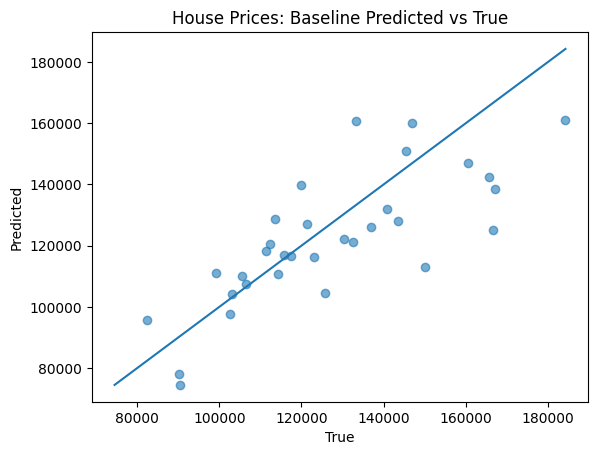

In [12]:
plot_pred_vs_true(y_test, pred_test, title="House Prices: Baseline Predicted vs True")


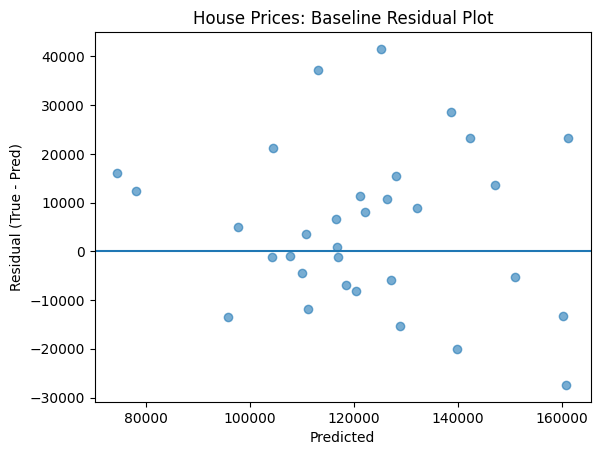

In [13]:
plot_residuals(y_test, pred_test, title="House Prices: Baseline Residual Plot")



### Interpreting coefficients (baseline)

Coefficients in linear regression have a straightforward meaning **conditional on other variables**.

If the model is:

$$
\hat{y} = \beta_0 + \beta_1 \cdot \text{SqFt} + \beta_2 \cdot \text{Bedrooms} + \cdots
$$

then $\beta_1$ is the expected change in predicted price when `SqFt` increases by 1 unit, **holding other included variables fixed**.

Important caveats:

- If features are correlated (e.g., `SqFt` and `Bedrooms`), coefficients represent partial effects and can be unintuitive.
- If you change feature scaling (e.g., meters vs feet), coefficients scale accordingly.
- Coefficients are not causal effects unless assumptions about confounding hold (see causal inference chapters later).

Let’s view the fitted baseline coefficients.


In [14]:
coef_base = pd.Series(lr_base.coef_, index=numeric_cols).sort_values(ascending=False)
coef_base


Bathrooms    11106.785718
Bedrooms      7580.383447
SqFt            73.666009
Home           -20.847094
Offers      -14632.022352
dtype: float64

In [15]:
pd.Series({"intercept": lr_base.intercept_}).to_frame("value")


,value
intercept,-29170.010941



### Improving the model: include categorical variables via a pipeline

To include categorical variables, we use one-hot encoding:

- A categorical feature with $k$ distinct values becomes $k$ binary columns.
- The model learns a separate coefficient for each category.

We build a `ColumnTransformer` that:
- passes numeric columns through unchanged
- one-hot encodes categorical columns

Then we train a single pipeline and evaluate on the test set.


In [16]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("lr", LinearRegression()),
])

model.fit(X_train, y_train)
pred_test2 = model.predict(X_test)
regression_report(y_test, pred_test2, label="Pipeline (num+cat) | ")


Pipeline (num+cat) | MAE : 8,338.0040
Pipeline (num+cat) | RMSE: 10,277.3255
Pipeline (num+cat) | R^2 : 0.8277


{'mae': np.float64(8338.00396657145),
 'rmse': np.float64(10277.32545732841),
 'r2': 0.8276990005560979}

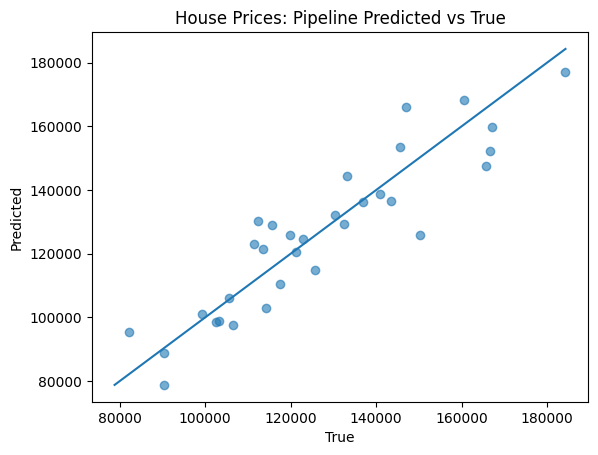

In [17]:
plot_pred_vs_true(y_test, pred_test2, title="House Prices: Pipeline Predicted vs True")


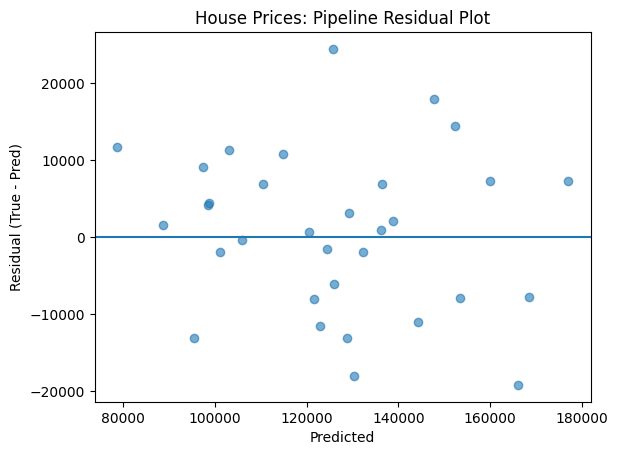

In [18]:
plot_residuals(y_test, pred_test2, title="House Prices: Pipeline Residual Plot")



### Recovering feature names and interpreting coefficients with one-hot encoding

After one-hot encoding, the model sees many columns. If we want interpretability, we must map coefficients back to feature names.


In [19]:
lr = model.named_steps["lr"]
ohe = model.named_steps["preprocess"].named_transformers_["cat"]

num_features = numeric_cols
cat_features = []
if len(categorical_cols) > 0:
    cat_features = ohe.get_feature_names_out(categorical_cols).tolist()

all_features = num_features + cat_features
coef = pd.Series(lr.coef_, index=all_features).sort_values(key=np.abs, ascending=False)
coef.head(20)


Neighborhood_West     13506.897292
Offers                -9073.637051
Brick_Yes              8311.090234
Brick_No              -8311.090234
Neighborhood_East     -7890.376421
Bathrooms              6971.407764
Neighborhood_North    -5616.520871
Bedrooms               3985.097414
SqFt                     61.871516
Home                     -8.556608
dtype: float64


### Multicollinearity: Variance Inflation Factor (VIF)

We compute a simple VIF score for numeric features. High VIF suggests coefficient instability.

This is a heuristic diagnostic, not a rule of physics.


In [20]:
def compute_vif(df_num):
    cols = df_num.columns
    vifs = {}
    for c in cols:
        X_others = df_num.drop(columns=[c])
        y_target = df_num[c]
        if X_others.shape[1] == 0:
            vifs[c] = 1.0
            continue
        lr_tmp = LinearRegression()
        lr_tmp.fit(X_others, y_target)
        r2 = lr_tmp.score(X_others, y_target)
        vifs[c] = float(1.0 / (1.0 - r2 + 1e-12))
    return pd.Series(vifs).sort_values(ascending=False)

compute_vif(df_house[numeric_cols])


SqFt         1.805441
Bathrooms    1.455524
Bedrooms     1.428800
Offers       1.152248
Home         1.087962
dtype: float64


## 8) Assumptions and diagnostics (practical view)

Linear regression is often described with a set of assumptions. In machine learning, we care about them mainly because they affect:

- **Predictive performance** (will the model generalize?)
- **Uncertainty and inference** (are standard errors and p-values meaningful?)

A commonly stated model is:

$$
y = \beta_0 + \sum_{j=1}^{d}\beta_j x_j + \epsilon
$$

The main ones you should recognize:

- Linearity (in your chosen feature space)
- Independence (no correlated errors)
- Homoscedasticity (constant variance)
- Normality (mainly for inference)
- No perfect multicollinearity

In ML practice, a good residual plot and honest validation protocol are usually more valuable than perfect theoretical assumptions.



## 9) Cross-validation (quick check)

A single train/test split is useful, but its result can vary. Cross-validation provides a more stable estimate of typical performance.

We compute RMSE scores across folds.


In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse_scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf)
rmse_scores = np.sqrt(-neg_mse_scores)
rmse_scores, rmse_scores.mean(), rmse_scores.std()


(array([10688.8323,  9314.452 , 12051.2938,  8329.6852,  9476.1963]),
 np.float64(9972.091930464847),
 np.float64(1281.6161610190659))


## 10) Hands-on Dataset 2: Diamonds (mixed numeric + categorical, large dataset)

Columns include:

- Numeric: `carat`, `depth`, `table`, `x`, `y`, `z`, ...
- Categorical: `cut`, `color`, `clarity`
- Target: `price`

We will sample for speed, fit a pipeline, then try a log-transform of the target.


In [22]:
diamonds_path = "../../../Datasets/Regression/diamonds.csv"
df_diamonds = pd.read_csv(diamonds_path)
df_diamonds.head()


,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [23]:
df_diamonds.shape


(53940, 11)

In [24]:
df_diamonds.isna().sum().sort_values(ascending=False).head(10)


id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
dtype: int64

In [25]:
df_diamonds_sample = df_diamonds.sample(n=min(15000, len(df_diamonds)), random_state=42)
df_diamonds_sample.shape


(15000, 11)

In [26]:
target2 = "price"
X2 = df_diamonds_sample.drop(columns=[target2])
y2 = df_diamonds_sample[target2]

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.25, random_state=42
)
mean_baseline_report(y2_train, y2_test, label="Diamonds mean baseline")

num2 = X2_train.select_dtypes(include=["number"]).columns.tolist()
cat2 = X2_train.select_dtypes(exclude=["number"]).columns.tolist()
num2, cat2


Diamonds mean baseline | MAE : 2,998.7483
Diamonds mean baseline | RMSE: 3,961.5989
Diamonds mean baseline | R^2 : -0.0004


(['id', 'carat', 'depth', 'table', 'x', 'y', 'z'], ['cut', 'color', 'clarity'])

In [27]:
preprocess2 = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num2),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat2),
    ]
)

model2 = Pipeline(steps=[
    ("preprocess", preprocess2),
    ("lr", LinearRegression()),
])

model2.fit(X2_train, y2_train)
pred2 = model2.predict(X2_test)
regression_report(y2_test, pred2, label="Diamonds (raw target) | ")


Diamonds (raw target) | MAE : 730.5917
Diamonds (raw target) | RMSE: 1,160.3020
Diamonds (raw target) | R^2 : 0.9142


{'mae': np.float64(730.5917321741703),
 'rmse': np.float64(1160.3020353379056),
 'r2': 0.9141845717854575}

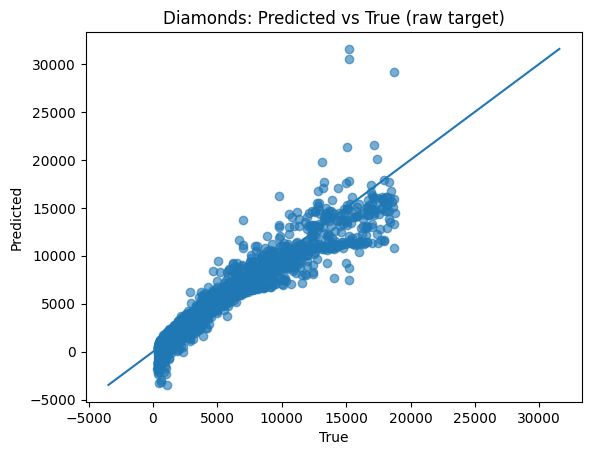

In [28]:
plot_pred_vs_true(y2_test, pred2, title="Diamonds: Predicted vs True (raw target)")


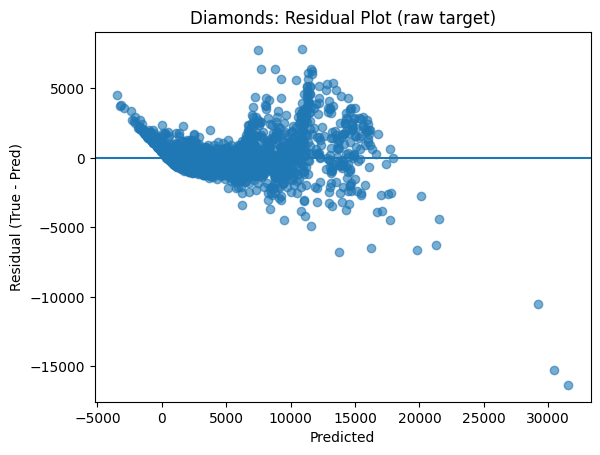

In [29]:
plot_residuals(y2_test, pred2, title="Diamonds: Residual Plot (raw target)")



### Quick numeric correlation view (diamonds)

Correlation is useful to detect redundant predictors and likely multicollinearity. We plot a simple correlation matrix for numeric columns.


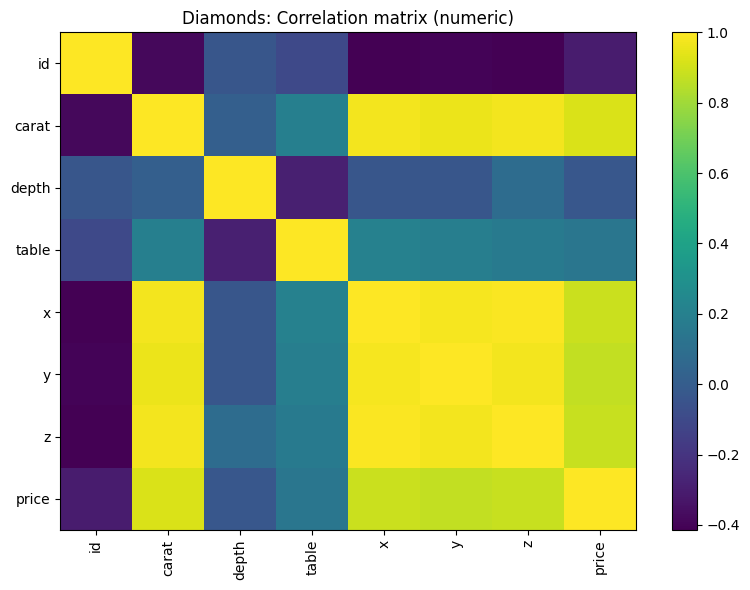

In [30]:
corr = df_diamonds_sample[num2 + [target2]].corr(numeric_only=True)
plt.figure(figsize=(8, 6))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Diamonds: Correlation matrix (numeric)")
plt.tight_layout()
plt.show()



### Optional improvement: log-transform the target

We model $\log(1+\text{price})$ and then invert with `expm1`.


In [31]:
y2_log = np.log1p(y2)

X2_train, X2_test, y2_log_train, y2_log_test = train_test_split(
    X2, y2_log, test_size=0.25, random_state=42
)

model2_log = Pipeline(steps=[
    ("preprocess", preprocess2),
    ("lr", LinearRegression()),
])

model2_log.fit(X2_train, y2_log_train)
pred2_log = model2_log.predict(X2_test)

print("Evaluation in log-space:")
regression_report(y2_log_test, pred2_log, label="Diamonds (log1p target) | ")

pred2_price = np.expm1(pred2_log)
y2_price_true = np.expm1(y2_log_test)

print("\nEvaluation back on price scale (naive inverse):")
regression_report(y2_price_true, pred2_price, label="Diamonds (back to price) | ")


Evaluation in log-space:
Diamonds (log1p target) | MAE : 0.1081
Diamonds (log1p target) | RMSE: 0.1566
Diamonds (log1p target) | R^2 : 0.9758

Evaluation back on price scale (naive inverse):
Diamonds (back to price) | MAE : 419.9949
Diamonds (back to price) | RMSE: 911.9209
Diamonds (back to price) | R^2 : 0.9470


{'mae': np.float64(419.99493614153414),
 'rmse': np.float64(911.9208694997429),
 'r2': 0.9469924690862342}

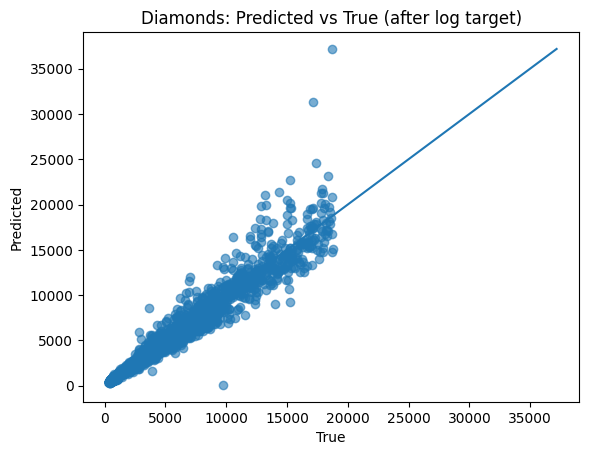

In [32]:
plot_pred_vs_true(y2_price_true, pred2_price, title="Diamonds: Predicted vs True (after log target)")


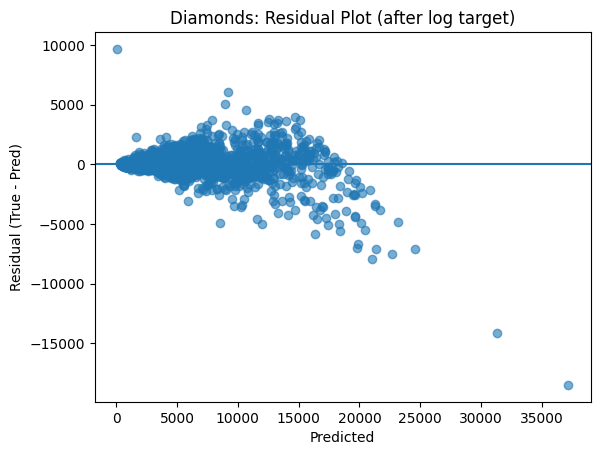

In [33]:
plot_residuals(y2_price_true, pred2_price, title="Diamonds: Residual Plot (after log target)")



## 11) Hands-on Dataset 3: Salaries (tiny dataset and instability)

With very few samples:
- estimates have high variance,
- splits can be misleading,
- coefficients may change dramatically with small perturbations.

We fit a pipeline and demonstrate instability via bootstrap.


In [34]:
salaries_path = "../../../Datasets/Regression/salaries.csv"
df_sal = pd.read_csv(salaries_path)
df_sal.head()


,Name,Age,Job,Salary
0,Kevin Sanders,24,Software Engineer,7300
1,Lisa Mills,26,High School Teacher,6100
2,Donna Allison,27,Dentist,12700
3,Michael Schmitt,43,Dentist,17500
4,Lisa Shaffer,31,Accountant,7400


In [35]:
df_sal.shape, df_sal.isna().sum()


((1000, 4),
 Name      0
 Age       0
 Job       0
 Salary    0
 dtype: int64)

In [36]:
target3 = "Salary"
X3 = df_sal.drop(columns=[target3])
y3 = df_sal[target3]

X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, test_size=0.25, random_state=42
)
mean_baseline_report(y3_train, y3_test, label="Salaries mean baseline")

num3 = X3_train.select_dtypes(include=["number"]).columns.tolist()
cat3 = X3_train.select_dtypes(exclude=["number"]).columns.tolist()

preprocess3 = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num3),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat3),
    ]
)

model3 = Pipeline(steps=[
    ("preprocess", preprocess3),
    ("lr", LinearRegression()),
])

model3.fit(X3_train, y3_train)
pred3 = model3.predict(X3_test)
regression_report(y3_test, pred3, label="Salaries (split) | ")


Salaries mean baseline | MAE : 3,528.3872
Salaries mean baseline | RMSE: 4,213.8058
Salaries mean baseline | R^2 : -0.0024
Salaries (split) | MAE : 1,568.5465
Salaries (split) | RMSE: 1,905.0038
Salaries (split) | R^2 : 0.7951


{'mae': np.float64(1568.5464873278263),
 'rmse': np.float64(1905.0038119920216),
 'r2': 0.795129629375023}

### Cross-validation on a tiny dataset

In [37]:
kf3 = KFold(n_splits=4, shuffle=True, random_state=42)
neg_mse3 = cross_val_score(model3, X3, y3, scoring="neg_mean_squared_error", cv=kf3)
rmse3 = np.sqrt(-neg_mse3)
rmse3, rmse3.mean(), rmse3.std()


(array([1905.0038, 3243.0599, 1609.632 , 3021.439 ]),
 np.float64(2444.783690838269),
 np.float64(699.7529717303206))

### Coefficient instability demonstration via bootstrap

In [38]:
def bootstrap_age_coefficient(df, n_boot=200, random_state=42):
    rng = np.random.default_rng(random_state)
    coefs = []
    for _ in range(n_boot):
        idx = rng.integers(0, len(df), size=len(df))
        boot = df.iloc[idx].copy()
        Xb = boot.drop(columns=["Salary"])
        yb = boot["Salary"]
        model3.fit(Xb, yb)
        lr3 = model3.named_steps["lr"]
        ohe3 = model3.named_steps["preprocess"].named_transformers_["cat"]
        num_features = num3
        cat_features = ohe3.get_feature_names_out(cat3).tolist() if len(cat3) else []
        feature_names = num_features + cat_features
        coef_series = pd.Series(lr3.coef_, index=feature_names)
        coefs.append(float(coef_series.get("Age", np.nan)))
    return pd.Series(coefs, name="Age_coef")

age_coefs = bootstrap_age_coefficient(df_sal, n_boot=300)
age_coefs.describe()


count    300.000000
mean     216.319527
std      167.746337
min     -266.621103
25%      102.551975
50%      272.746281
75%      297.950727
max      733.280620
Name: Age_coef, dtype: float64

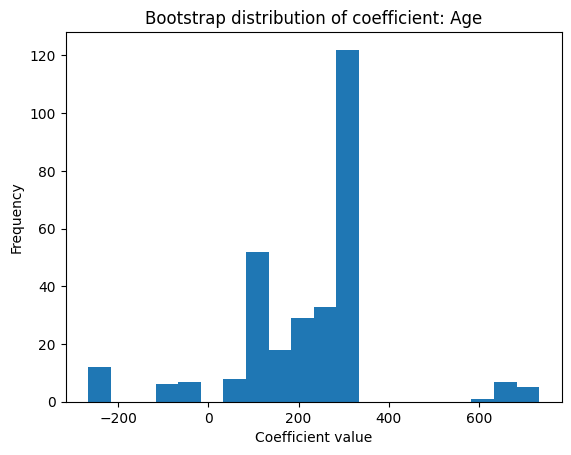

In [39]:
plt.figure()
plt.hist(age_coefs.dropna(), bins=20)
plt.title("Bootstrap distribution of coefficient: Age")
plt.xlabel("Coefficient value")
plt.ylabel("Frequency")
plt.show()



## 12) Training “from scratch”: gradient descent for linear regression

We implement batch gradient descent for intuition and compare with scikit-learn on standardized features.


In [40]:
X_gd = X_train_num.to_numpy(dtype=float)
y_gd = y_train.to_numpy(dtype=float)

# Standardize features for optimization stability (manual)
X_mean = X_gd.mean(axis=0)
X_std = X_gd.std(axis=0) + 1e-12
X_gd_s = (X_gd - X_mean) / X_std

def fit_linear_regression_gd(X, y, lr=0.05, n_iter=2000):
    n, d = X.shape
    beta0 = 0.0
    beta = np.zeros(d)
    losses = []
    for _ in range(n_iter):
        y_hat = beta0 + X @ beta
        err = y_hat - y
        loss = np.mean(err**2)
        losses.append(loss)
        # gradients
        g0 = 2.0 * np.mean(err)
        g = 2.0 * (X.T @ err) / n
        beta0 -= lr * g0
        beta  -= lr * g
    return beta0, beta, np.array(losses)

beta0_gd, beta_gd, losses = fit_linear_regression_gd(X_gd_s, y_gd, lr=0.05, n_iter=3000)
losses[:5], losses[-5:]


(array([1.8069e+10, 1.4648e+10, 1.1889e+10, 9.6615e+09, 7.8616e+09]),
 array([2.0252e+08, 2.0252e+08, 2.0252e+08, 2.0252e+08, 2.0252e+08]))

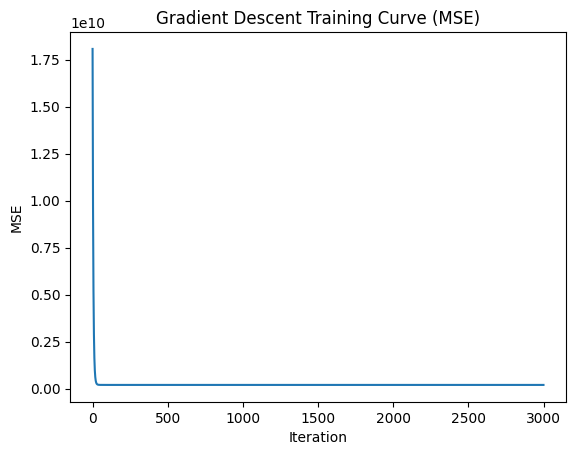

In [41]:
plt.figure()
plt.plot(losses)
plt.title("Gradient Descent Training Curve (MSE)")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()


In [42]:
# Compare with scikit-learn solution on the same standardized features
lr_sklearn = LinearRegression()
lr_sklearn.fit(X_gd_s, y_gd)

print("GD intercept:", beta0_gd)
print("sklearn intercept:", lr_sklearn.intercept_)
print("\nGD coefficients:")
print(beta_gd)
print("\nsklearn coefficients:")
print(lr_sklearn.coef_)


GD intercept: 131618.74999999988
sklearn intercept: 131618.75

GD coefficients:
[  -770.7161  15387.0583   5543.1329   5780.1545 -15797.7745]

sklearn coefficients:
[  -770.7161  15387.0583   5543.1329   5780.1545 -15797.7745]



## 13) Optional: classical inference and diagnostics with statsmodels

If `statsmodels` is available, we fit an OLS model for the house price data and show standard outputs and a Breusch–Pagan test.


In [43]:
if HAS_STATSMODELS:
    # Fit OLS using numeric-only baseline for simplicity
    X_sm = sm.add_constant(X_train_num)
    ols = sm.OLS(y_train, X_sm).fit()
    print(ols.summary())
else:
    print("statsmodels is not available in this environment.")


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     48.22
Date:                Sun, 25 Jan 2026   Prob (F-statistic):           5.19e-24
Time:                        22:03:23   Log-Likelihood:                -1054.3
No. Observations:                  96   AIC:                             2121.
Df Residuals:                      90   BIC:                             2136.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.917e+04   1.46e+04     -1.996      0.0

In [44]:
if HAS_STATSMODELS:
    # Breusch-Pagan test for heteroskedasticity
    resid = ols.resid
    exog = ols.model.exog
    bp_test = sms.het_breuschpagan(resid, exog)
    labels = ["LM stat", "LM p-value", "F stat", "F p-value"]
    print(dict(zip(labels, bp_test)))
else:
    pass


{'LM stat': np.float64(5.277953756179006), 'LM p-value': np.float64(0.3829083760951281), 'F stat': np.float64(1.0471894268775128), 'F p-value': np.float64(0.3951125968460608)}



## 14) Wrap-up

You learned how linear regression works (OLS and metrics), how to use pipelines and one-hot encoding safely, and how to evaluate and diagnose models across multiple datasets.

Next lesson: Logistic Regression (same workflow, different target type).
